## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Import Data

In [2]:
dataset = pd.read_excel("Prepared_Datasets/merged_VNIR_SWIR_add_light_intensity.xlsx")
target = pd.read_excel("Sugar_Quantities.xlsx")

In [3]:
dataset.head(3)

,Img_name,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,Band_8,Band_9,...,Band_407,Band_408,Band_409,Band_410,Band_411,Band_412,Band_413,Band_414,Band_415,Band_416
0,38367,2272.052376,2419.640964,2530.859162,2612.018388,2718.413619,2826.046004,2878.306089,3073.544431,3229.561130,...,2749.09,2683.93,2683.91,2628.19,2563.28,2437.80,2340.47,2268.82,2193.45,2151.58
1,38368,1822.574497,1917.456792,2003.750927,2079.778647,2153.134286,2230.324596,2276.387512,2428.686721,2552.277473,...,2170.60,2113.64,2120.91,2036.49,1966.49,1856.88,1804.88,1721.17,1650.61,1630.31
2,38369,1931.785921,2051.129682,2138.022522,2228.502649,2314.158989,2410.505299,2454.436973,2629.315374,2760.096754,...,2268.63,2224.43,2232.75,2172.08,2139.10,2025.87,1931.90,1871.97,1819.16,1791.44


In [4]:
target_columns = ['Barcode', 'Print_Info', 'Variety_ID', 'Variety', 'Batch', 'Sample', 'Glucose', 'Fructose', 'Sucrose', 'Raffinose',
                 'Kestose', 'Maltose', 'Nystose', 'Kestopentaose', 'Total_Fructan']
target.columns = target_columns

In [5]:
# g = sns.pairplot(target[['Glucose','Fructose','Sucrose', 'Raffinose', 'Kestose', 'Maltose', 'Nystose', 'Kestopentaose']])

In [6]:
cor2 = target.iloc[:, [7, 8, 9, 10, 11, 12, 13, 14]].corr()

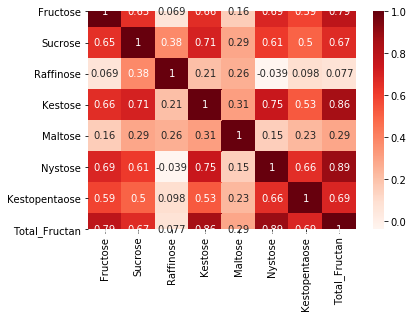

In [7]:
sns.heatmap(cor2, annot=True, cmap=plt.cm.Reds)
plt.show()

### adding helper columns on target dataset

#### adding counts of varieties

In [8]:
counts = pd.value_counts(target['Variety_ID'])
counts_index = np.array([counts.index]).reshape(-1, 1)
counts_values = np.array([counts.values]).reshape(-1, 1)

In [9]:
counts_data = np.concatenate((counts_index, counts_values),axis = 1)

In [10]:
counts_df = pd.DataFrame(data = counts_data, columns = ['Variety_ID', 'Variety_counts'])

In [11]:
target = pd.merge(left = target, right = counts_df, how = 'outer', left_on = 'Variety_ID', right_on = 'Variety_ID')

In [12]:
# target.head(2)

#### adding variety number of counts

In [13]:
target.insert(loc = 16, column = "Variety_number", value = "")

In [14]:
for r in range(0, target.shape[0]):
    num = 0
    Variety_ID = target.Variety_ID[r]
    for x in range(r, target.shape[0]):
        if target.Variety_ID[x] == Variety_ID:
            num = num + 1
    target.Variety_number[r] = num

C:\Users\ahmad\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [15]:
target.head(3)

,Barcode,Print_Info,Variety_ID,Variety,Batch,Sample,Glucose,Fructose,Sucrose,Raffinose,Kestose,Maltose,Nystose,Kestopentaose,Total_Fructan,Variety_counts,Variety_number
0,38368.0,Cabaret-R1_L1P3,26,Cabaret,1,1,0.525990,0.389049,14.139681,6.957827,2.297757,0.607435,0.838198,0.068990,7.209828,3,3
1,38632.0,Cabaret-R2_L12P3,26,Cabaret,11,251,0.587680,0.594920,14.475188,5.263027,2.500238,0.577737,0.980051,0.070338,6.219160,3,2
2,38765.0,Cabaret-R3_L17P16,26,Cabaret,18,413,0.383404,0.329895,9.469324,3.742113,1.605575,0.640902,0.251107,0.015643,4.087977,3,1


### Prepare dataset with different scalings to try each and find which one works better

#### Max_min scaler, scaling dataset in the range of 0 and 1

In [16]:
scaler = MinMaxScaler()
scaled_dataset = dataset.iloc[:, 1:]
min_max_scaled_dataset = scaler.fit_transform(scaled_dataset)

In [17]:
min_max_scaled_dataset = pd.DataFrame(data = min_max_scaled_dataset)
min_max_scaled_dataset.insert(loc = 0, column = "img", value = dataset.Img_name)
min_max_scaled_dataset.columns = dataset.columns

In [18]:
min_max_scaled_dataset = pd.merge(left = min_max_scaled_dataset, right = target, how = "inner", left_on = "Img_name", right_on = "Barcode")
min_max_scaled_dataset.head(3)

,Img_name,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,Band_8,Band_9,...,Fructose,Sucrose,Raffinose,Kestose,Maltose,Nystose,Kestopentaose,Total_Fructan,Variety_counts,Variety_number
0,38367,0.453739,0.445624,0.444130,0.449550,0.458939,0.476805,0.513596,0.476022,0.478778,...,0.938528,11.580359,7.191522,2.508236,1.132254,0.454942,0.493446,7.451642,3,2
1,38368,0.336197,0.328566,0.328909,0.336866,0.342283,0.354602,0.383138,0.355403,0.357803,...,0.389049,14.139681,6.957827,2.297757,0.607435,0.838198,0.068990,7.209828,3,3
2,38369,0.364757,0.359725,0.358259,0.368353,0.375514,0.391563,0.421728,0.392930,0.394923,...,0.364791,11.247442,5.236240,2.417849,0.497984,1.378649,0.221425,8.311020,3,3


#### not scaled dataset

In [19]:
not_scaled_dataset = pd.merge(left = dataset, right = target, how = "inner", left_on = "Img_name", right_on = "Barcode")
not_scaled_dataset.head(3)

,Img_name,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,Band_8,Band_9,...,Fructose,Sucrose,Raffinose,Kestose,Maltose,Nystose,Kestopentaose,Total_Fructan,Variety_counts,Variety_number
0,38367,2272.052376,2419.640964,2530.859162,2612.018388,2718.413619,2826.046004,2878.306089,3073.544431,3229.561130,...,0.938528,11.580359,7.191522,2.508236,1.132254,0.454942,0.493446,7.451642,3,2
1,38368,1822.574497,1917.456792,2003.750927,2079.778647,2153.134286,2230.324596,2276.387512,2428.686721,2552.277473,...,0.389049,14.139681,6.957827,2.297757,0.607435,0.838198,0.068990,7.209828,3,3
2,38369,1931.785921,2051.129682,2138.022522,2228.502649,2314.158989,2410.505299,2454.436973,2629.315374,2760.096754,...,0.364791,11.247442,5.236240,2.417849,0.497984,1.378649,0.221425,8.311020,3,3


## Datasets

### Randomly Splitting dataset

In [20]:
X_not_scaled = not_scaled_dataset.iloc[:, 1:417]
y_not_scaled = not_scaled_dataset.iloc[:, 423:432]

In [25]:
X_min_max = min_max_scaled_dataset.iloc[:, 1:417]
y_min_max = min_max_scaled_dataset.iloc[:, 423:432]

In [26]:
# ************************** no scaled training and test split based on varieties ***************************

X_train_not_scaled, X_test_not_scaled, y_train_not_scaled, y_test_not_scaled = train_test_split(X_not_scaled, y_not_scaled, test_size=0.25)

# *************************** min max training and test split based on varieties ****************************

# X_train_min_max, X_test_min_max, y_train_min_max, y_test_min_max = train_test_split(X_min_max, y_min_max, test_size=0.25)

# Algorithms

## Lasso

In [27]:
target.columns

Index(['Barcode', 'Print_Info', 'Variety_ID', 'Variety', 'Batch', 'Sample',
       'Glucose', 'Fructose', 'Sucrose', 'Raffinose', 'Kestose', 'Maltose',
       'Nystose', 'Kestopentaose', 'Total_Fructan', 'Variety_counts',
       'Variety_number'],
      dtype='object')

In [28]:
y_train_not_scaled_Glucose = y_train_not_scaled.Glucose
y_train_not_scaled_Fructose = y_train_not_scaled.Fructose
y_train_not_scaled_Sucrose = y_train_not_scaled.Sucrose
y_train_not_scaled_Raffinose = y_train_not_scaled.Raffinose
y_train_not_scaled_Kestose = y_train_not_scaled.Kestose
y_train_not_scaled_Maltose = y_train_not_scaled.Maltose
y_train_not_scaled_Nystose = y_train_not_scaled.Nystose
y_train_not_scaled_Kestopentaose = y_train_not_scaled.Kestopentaose
y_train_not_scaled_Total_Fructan = y_train_not_scaled.Total_Fructan

y_test_not_scaled_Glucose = y_test_not_scaled.Glucose
y_test_not_scaled_Fructose = y_test_not_scaled.Fructose
y_test_not_scaled_Sucrose = y_test_not_scaled.Sucrose
y_test_not_scaled_Raffinose = y_test_not_scaled.Raffinose
y_test_not_scaled_Kestose = y_test_not_scaled.Kestose
y_test_not_scaled_Maltose = y_test_not_scaled.Maltose
y_test_not_scaled_Nystose = y_test_not_scaled.Nystose
y_test_not_scaled_Kestopentaose = y_test_not_scaled.Kestopentaose
y_test_not_scaled_Total_Fructan = y_test_not_scaled.Total_Fructan

In [29]:
lasso_not_scaled_Glucose = linear_model.Lasso(max_iter=100000, tol=0.001)
lasso_not_scaled_Fructose = linear_model.Lasso(max_iter=100000, tol=0.001)
lasso_not_scaled_Sucrose = linear_model.Lasso(max_iter=100000, tol=0.001)
lasso_not_scaled_Raffinose = linear_model.Lasso(max_iter=100000, tol=0.001)
lasso_not_scaled_Kestose = linear_model.Lasso(max_iter=100000, tol=0.001)
lasso_not_scaled_Maltose = linear_model.Lasso(max_iter=100000, tol=0.001)
lasso_not_scaled_Nystose = linear_model.Lasso(max_iter=100000, tol=0.001)
lasso_not_scaled_Kestopentaose = linear_model.Lasso(max_iter=100000, tol=0.001)
lasso_not_scaled_Total_Fructan = linear_model.Lasso(max_iter=100000, tol=0.001)

In [30]:
lasso_not_scaled_Glucose.fit(X_train_not_scaled, y_train_not_scaled_Glucose)
lasso_not_scaled_Fructose.fit(X_train_not_scaled, y_train_not_scaled_Fructose)
lasso_not_scaled_Sucrose.fit(X_train_not_scaled, y_train_not_scaled_Sucrose)
lasso_not_scaled_Raffinose.fit(X_train_not_scaled, y_train_not_scaled_Raffinose)
lasso_not_scaled_Kestose.fit(X_train_not_scaled, y_train_not_scaled_Kestose)
lasso_not_scaled_Maltose.fit(X_train_not_scaled, y_train_not_scaled_Maltose)
lasso_not_scaled_Nystose.fit(X_train_not_scaled, y_train_not_scaled_Nystose)
lasso_not_scaled_Kestopentaose.fit(X_train_not_scaled, y_train_not_scaled_Kestopentaose)
lasso_not_scaled_Total_Fructan.fit(X_train_not_scaled, y_train_not_scaled_Total_Fructan)

C:\Users\ahmad\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 299.4048267104209, tolerance: 1.9558149282916897
  positive)
C:\Users\ahmad\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.018081617815483, tolerance: 0.7306707454899025
  positive)
C:\Users\ahmad\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4581295149988023, tolerance: 0.28658753067947035
  positive)
C:\Users\ahmad\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=100000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.001, warm_start=False)

In [31]:
prediction_not_scaled_Glucose = lasso_not_scaled_Glucose.predict(X_test_not_scaled)
prediction_not_scaled_Fructose = lasso_not_scaled_Fructose.predict(X_test_not_scaled)
prediction_not_scaled_Sucrose = lasso_not_scaled_Sucrose.predict(X_test_not_scaled)
prediction_not_scaled_Raffinose = lasso_not_scaled_Raffinose.predict(X_test_not_scaled)
prediction_not_scaled_Kestose = lasso_not_scaled_Kestose.predict(X_test_not_scaled)
prediction_not_scaled_Maltose = lasso_not_scaled_Maltose.predict(X_test_not_scaled)
prediction_not_scaled_Nystose = lasso_not_scaled_Nystose.predict(X_test_not_scaled)
prediction_not_scaled_Kestopentaose = lasso_not_scaled_Kestopentaose.predict(X_test_not_scaled)
prediction_not_scaled_Total_Fructan = lasso_not_scaled_Total_Fructan.predict(X_test_not_scaled)

In [32]:
variance_not_scaled_Glucose = lasso_not_scaled_Glucose.score(X_test_not_scaled, y_test_not_scaled_Glucose)
variance_not_scaled_Fructose = lasso_not_scaled_Fructose.score(X_test_not_scaled, y_test_not_scaled_Fructose)
variance_not_scaled_Sucrose = lasso_not_scaled_Sucrose.score(X_test_not_scaled, y_test_not_scaled_Sucrose)
variance_not_scaled_Raffinose = lasso_not_scaled_Raffinose.score(X_test_not_scaled, y_test_not_scaled_Raffinose)
variance_not_scaled_Kestose = lasso_not_scaled_Kestose.score(X_test_not_scaled, y_test_not_scaled_Kestose)
variance_not_scaled_Maltose = lasso_not_scaled_Maltose.score(X_test_not_scaled, y_test_not_scaled_Maltose)
variance_not_scaled_Nystose = lasso_not_scaled_Nystose.score(X_test_not_scaled, y_test_not_scaled_Nystose)
variance_not_scaled_Kestopentaose = lasso_not_scaled_Kestopentaose.score(X_test_not_scaled, y_test_not_scaled_Kestopentaose)
variance_not_scaled_Total_Fructan = lasso_not_scaled_Total_Fructan.score(X_test_not_scaled, y_test_not_scaled_Total_Fructan)

In [33]:
print(variance_not_scaled_Glucose)
print(variance_not_scaled_Fructose)
print(variance_not_scaled_Sucrose)
print(variance_not_scaled_Raffinose)
print(variance_not_scaled_Kestose)
print(variance_not_scaled_Maltose)
print(variance_not_scaled_Nystose)
print(variance_not_scaled_Kestopentaose)
print(variance_not_scaled_Total_Fructan)

0.00801053182182676
0.001329250275322269
-0.21549367016523835
-0.09150020414786475
-0.2581450115989823
0.06848176440770448
-0.13238415914446144
-0.026344329345600714
-0.3655196146977803


In [34]:
# r2_score_min_max_Glucose = r2_score(y_test_min_max_Glucose, prediction_min_max_Glucose)
# r2_score_min_max_Fructose = r2_score(y_test_min_max_Fructose, prediction_min_max_Fructose)
# r2_score_min_max_Sucrose = r2_score(y_test_min_max_Sucrose, prediction_min_max_Sucrose)
# r2_score_min_max_Raffinose = r2_score(y_test_min_max_Raffinose, prediction_min_max_Raffinose)
# r2_score_min_max_Kestose = r2_score(y_test_min_max_Kestose, prediction_min_max_Kestose)
# r2_score_min_max_Maltose = r2_score(y_test_min_max_Maltose, prediction_min_max_Maltose)
# r2_score_min_max_Nystose = r2_score(y_test_min_max_Nystose, prediction_min_max_Nystose)
# r2_score_min_max_Kestopentaose = r2_score(y_test_min_max_Kestopentaose, prediction_min_max_Kestopentaose)
# r2_score_min_max_Total_Fructan = r2_score(y_test_min_max_Total_Fructan, prediction_min_max_Total_Fructan)

In [35]:
# print(r2_score_min_max_Glucose)
# print(r2_score_min_max_Fructose)
# print(r2_score_min_max_Sucrose)
# print(r2_score_min_max_Raffinose)
# print(r2_score_min_max_Kestose)
# print(r2_score_min_max_Maltose)
# print(r2_score_min_max_Nystose)
# print(r2_score_min_max_Kestopentaose)
# print(r2_score_min_max_Total_Fructan)

In [36]:
mean_absolute_error_not_scaled_Glucose = mean_absolute_error(y_test_not_scaled_Glucose, prediction_not_scaled_Glucose)
mean_absolute_error_not_scaled_Fructose = mean_absolute_error(y_test_not_scaled_Fructose, prediction_not_scaled_Fructose)
mean_absolute_error_not_scaled_Sucrose = mean_absolute_error(y_test_not_scaled_Sucrose, prediction_not_scaled_Sucrose)
mean_absolute_error_not_scaled_Raffinose = mean_absolute_error(y_test_not_scaled_Raffinose, prediction_not_scaled_Raffinose)
mean_absolute_error_not_scaled_Kestose = mean_absolute_error(y_test_not_scaled_Kestose, prediction_not_scaled_Kestose)
mean_absolute_error_not_scaled_Maltose = mean_absolute_error(y_test_not_scaled_Maltose, prediction_not_scaled_Maltose)
mean_absolute_error_not_scaled_Nystose = mean_absolute_error(y_test_not_scaled_Nystose, prediction_not_scaled_Nystose)
mean_absolute_error_not_scaled_Kestopentaose = mean_absolute_error(y_test_not_scaled_Kestopentaose, prediction_not_scaled_Kestopentaose)
mean_absolute_error_not_scaled_Total_Fructan = mean_absolute_error(y_test_not_scaled_Total_Fructan, prediction_not_scaled_Total_Fructan)

In [37]:
print(mean_absolute_error_not_scaled_Glucose)
print(mean_absolute_error_not_scaled_Fructose)
print(mean_absolute_error_not_scaled_Sucrose)
print(mean_absolute_error_not_scaled_Raffinose)
print(mean_absolute_error_not_scaled_Kestose)
print(mean_absolute_error_not_scaled_Maltose)
print(mean_absolute_error_not_scaled_Nystose)
print(mean_absolute_error_not_scaled_Kestopentaose)
print(mean_absolute_error_not_scaled_Total_Fructan)

0.2114520170357746
0.2619866163159974
1.9246175066297402
0.952037473353029
0.6734195099034119
0.1722448675581592
0.6518017733415485
0.20613925389532012
3.3749288866568317


In [38]:
y_test_not_scaled_Glucose = y_test_not_scaled.Glucose
y_test_not_scaled_Fructose = y_test_not_scaled.Fructose
y_test_not_scaled_Sucrose = y_test_not_scaled.Sucrose
y_test_not_scaled_Raffinose = y_test_not_scaled.Raffinose
y_test_not_scaled_Kestose = y_test_not_scaled.Kestose
y_test_not_scaled_Maltose = y_test_not_scaled.Maltose
y_test_not_scaled_Nystose = y_test_not_scaled.Nystose
y_test_not_scaled_Kestopentaose = y_test_not_scaled.Kestopentaose
y_test_not_scaled_Total_Fructan = y_test_not_scaled.Total_Fructan

In [39]:
mean_squared_error_Glucose = mean_squared_error(y_test_not_scaled_Glucose, prediction_not_scaled_Glucose)
mean_squared_error_Fructose = mean_squared_error(y_test_not_scaled_Fructose, prediction_not_scaled_Fructose)
mean_squared_error_Sucrose = mean_squared_error(y_test_not_scaled_Sucrose, prediction_not_scaled_Sucrose)
mean_squared_error_Raffinose = mean_squared_error(y_test_not_scaled_Raffinose, prediction_not_scaled_Raffinose)
mean_squared_error_Kestose = mean_squared_error(y_test_not_scaled_Kestose, prediction_not_scaled_Kestose)
mean_squared_error_Maltose = mean_squared_error(y_test_not_scaled_Maltose, prediction_not_scaled_Maltose)
mean_squared_error_Nystose = mean_squared_error(y_test_not_scaled_Nystose, prediction_not_scaled_Nystose)
mean_squared_error_Kestopentaose = mean_squared_error(y_test_not_scaled_Kestopentaose, prediction_not_scaled_Kestopentaose)
mean_squared_error_Total_Fructan = mean_squared_error(y_test_not_scaled_Total_Fructan, prediction_not_scaled_Total_Fructan)

In [40]:
print(mean_squared_error_Glucose)
print(mean_squared_error_Fructose)
print(mean_squared_error_Sucrose)
print(mean_squared_error_Raffinose)
print(mean_squared_error_Kestose)
print(mean_squared_error_Maltose)
print(mean_squared_error_Nystose)
print(mean_squared_error_Kestopentaose)
print(mean_squared_error_Total_Fructan)

0.07373341770299019
0.11532887285201587
5.414433369817864
1.402225526804981
0.6778266318995044
0.051875682195227986
0.6828186828914197
0.07557722478744937
18.558572170938287


##### visualization

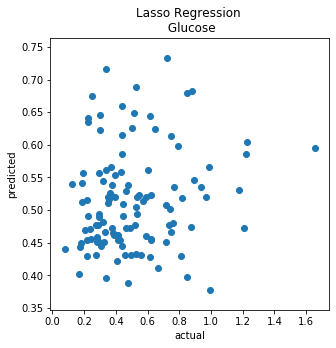

In [41]:
plt.figure(figsize=(5,5))
plt.title("Lasso Regression \n Glucose")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.scatter(y_test_not_scaled_Glucose, prediction_not_scaled_Glucose)

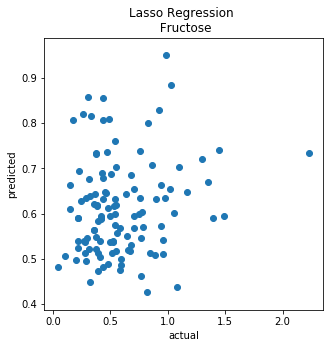

In [42]:
plt.figure(figsize=(5,5))
plt.title("Lasso Regression \n Fructose")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.scatter(y_test_not_scaled_Fructose, prediction_not_scaled_Fructose)

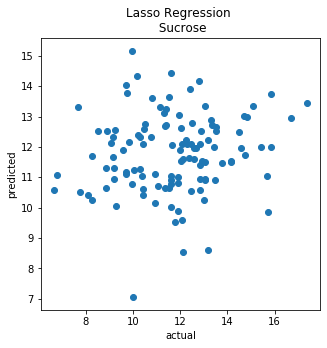

In [43]:
plt.figure(figsize=(5,5))
plt.title("Lasso Regression \n Sucrose")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.scatter(y_test_not_scaled_Sucrose, prediction_not_scaled_Sucrose)

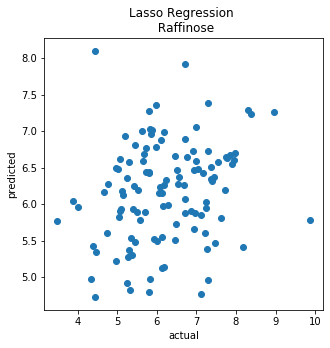

In [44]:
plt.figure(figsize=(5,5))
plt.title("Lasso Regression \n Raffinose")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.scatter(y_test_not_scaled_Raffinose, prediction_not_scaled_Raffinose)

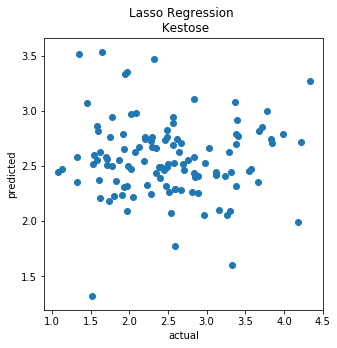

In [45]:
plt.figure(figsize=(5,5))
plt.title("Lasso Regression \n Kestose")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.scatter(y_test_not_scaled_Kestose, prediction_not_scaled_Kestose)

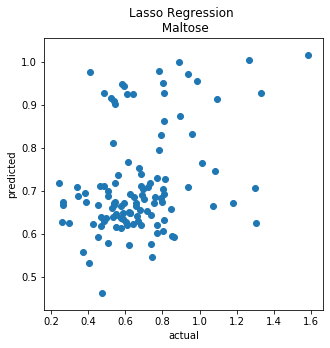

In [46]:
plt.figure(figsize=(5,5))
plt.title("Lasso Regression \n Maltose")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.scatter(y_test_not_scaled_Maltose, prediction_not_scaled_Maltose)

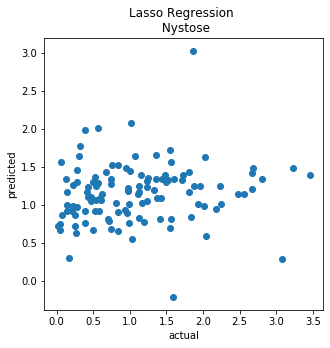

In [47]:
plt.figure(figsize=(5,5))
plt.title("Lasso Regression \n Nystose")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.scatter(y_test_not_scaled_Nystose, prediction_not_scaled_Nystose)

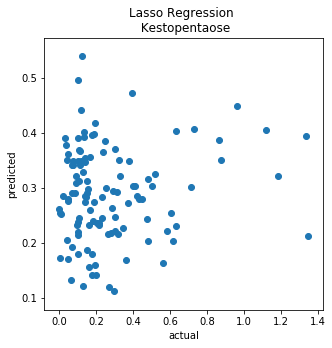

In [48]:
plt.figure(figsize=(5,5))
plt.title("Lasso Regression \n Kestopentaose")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.scatter(y_test_not_scaled_Kestopentaose, prediction_not_scaled_Kestopentaose)

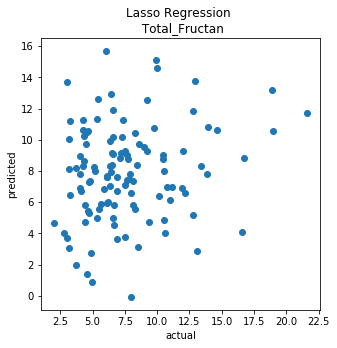

In [49]:
plt.figure(figsize=(5,5))
plt.title("Lasso Regression \n Total_Fructan")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.scatter(y_test_not_scaled_Total_Fructan, prediction_not_scaled_Total_Fructan)

In [46]:
# slope = elasticNet.coef_
# slope.max()

In [47]:
# intercept = elasticNet.intercept_
# print(intercept)